# Lab 2 Part 2: Transfer Learning with Pytorch
The goal for the second part of the lab is to familiarize you with another technique to train deep neural networks called transfer learning. Typically in neural networks you will have a lot of layers and not enough training data. This is especially true for this class, where the amount of data and types of differently annotated data we can get are very limited. Typically, neural networks are fed with millions of images in order to generalize well. The good thing is, if someone hands us a pretrained network we can still "use" all that data they trained with by retraining the parameters for our purposes. In this case, we will continue with our car classifier. 

## Import the necessary libraries
We will import Pytorch and various modules within it, as well as numpy, matplotlib, and some Python system libraries.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset as Dataset

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
import numpy as np

from torch.utils.data import DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import Linear

from skimage import io

import time
import os
import copy

In [2]:
torch.cuda.init() #DELETE ME
USE_GPU = torch.cuda.is_available()
print("GPU AVAILABLE: ", USE_GPU)

GPU AVAILABLE:  True


In this step of the lab, you will construct a data loader to actually import the images from our dataset. Luckily, Pytorch has built in support for dataset objects. In this section, we have provided skeleton code for a dataset object. Please refer to the [Pytorch documentation](https://pytorch.org/docs/0.4.0/), as well as this [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to figure out how to properly load data for a neural network. 

In [3]:
# Car Dataset Object
# Child of Dataset class
class CarDataSet(Dataset):
    # CarDataset constructor
    # Inputs:
    # path - string containing path to a directory of car dataset images
    # transform - a transform to be done on the image; defaults to none if 
    #     no transforms are needed
    def __init__(self, path, transform=None):
        self.path      = path
        self.transform = transform
        self.imageList = os.listdir(self.path)
    
    # Retrieves image at specified index and returns the image along with a label
    # Inputs:
    # idx - specified image index
    # Outputs:
    # sample - structures containing images and their corresponding labels
    def __getitem__(self, idx):
        ### TODO ###
        #READ IMAGE AND LABEL
        imageName = self.imageList[idx]
        image = os.path.join(self.path, imageName)
        label = 0
        if imageName[0:3] == "pos" or imageName[0:4] == "test":
            label = 1
            
        image = Image.open(image).convert("RGB")
        if self.transform != None:
            image = self.transform(image)
            
        sample = (image, label)
        return sample
    
    # Return the number of images in the dataset
    def __len__(self):
        return len(self.imageList)
    
    # Plot and visualize an image and its corresponding label
    def visualize(self, idx):
        img_name = self.imageList[idx]
        img_loc = os.path.join(self.path, img_name)
        image = io.imread(img_loc)
        _, label = self.__getitem__(idx)
        plt.imshow(image)
        # PRINT LABEL ON IMAGE
        plt.show()

## Import the dataset into a data loader object
After constructing the dataset, we want to get it into a dataloader object as well as apply any necessary transformations on the image. Again, please refer to the [Pytorch documentation](https://pytorch.org/docs/0.4.0/), as well as the previously mentioned [data processing tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). You must apply two transforms at minimum, one to convert the images to torch tensors, and the other to normalize the images. 

In [4]:
### TODO ###
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset_train = CarDataSet("/LAB2/Phase2/TrainImages/", trans)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=False) 
print("Number images in training set: ", len(dataset_train))

Number images in training set:  1050


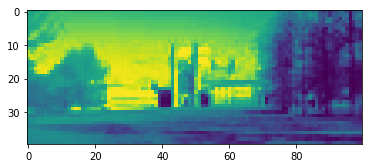

In [5]:
dataset_train.visualize(0)

## Model Definition
Now that the data has been loaded into a data loader object, we can define our model. We will be using the resnet18 architecture ([original paper](https://arxiv.org/pdf/1512.03385.pdf)) with pretrained weights on the [ImageNet dataset](http://www.image-net.org/). In order to do transfer learning, we need to redefine the last fully connected layer in the pretrained model, and then retrain the whole network with our new final layer and new images. In this section, you need to redefine the new layer, choose an optimizer, and choose a loss function for the model. After doing so, you will create a training function to actually train model. 

In [6]:
model_resnet18 = models.resnet18(pretrained=True)

#TAKE LAST FULLY CONNECTED LAYER AND MAKE IT ONLY HAVE TWO OUTPUT NODES
#print(model_resnet18.parameters)
model_resnet18.fc = Linear(in_features=512, out_features=2, bias=True)
if USE_GPU:
    model_resnet18 = model_resnet18.cuda()
    
# Loss function and optimizer
loss_resnet18 = CrossEntropyLoss()
optimizer_resnet18 = SGD(model_resnet18.parameters(), lr=0.0001, momentum=0.1, nesterov=True)

## Creating the training loop
The last step of the lab is to create the training loop. There are 5 parameters in our training function, all of them are neural network hyperparameters. We have the model architecture, loss function, optimizer, and learning rate. The fifth hyperparameter we work with here is the number of epochs. This is a measure of the number of times you want the model to 'see' the training set. The default value is 25 times, but the model may need more or less passes in order to generalize well. Your goal for this section is to write the training loop to train this model. Recall from lecture that there are 4 main steps to training a model. 
1. Inference/Current Prediction
2. Compute the loss for the current prediction
3. Compute the gradients of the loss with respect to the model parameters using backpropagation
4. Update model weights and repeat

Again, refer to the [Pytorch documentation](https://pytorch.org/docs/0.4.0/) as well as the following [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

In [7]:
def train_model(model, loss_func, optimizer, lr_scheduler, num_epochs=25):
    stamp = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_loss = 99999999999999999999
    
    # Loop over the number of epochs
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 20)
        
        running_loss = 0.0
        
        for i, sample in enumerate(dataloader_train, 0):
            x, y_real = sample  # get the inputs
            if USE_GPU:
                x = x.cuda()
                y_real = y_real.cuda()

            optimizer.zero_grad() # zero the parameter gradients
            y_predict = model(x)  # Forward propogation
            loss = loss_func(y_predict, y_real)  # Calculate loss between y_predict and y_real
            loss.backward()   # Back propagation (just calculates the derivatives)
            optimizer.step()  # Use derivatives to step in correct direction

            # print statistics
            ### TODO: Add running loss ###
            running_loss += loss.item()

        ### TODO: Compute loss for whole epoch
        epoch_loss = running_loss * 1.0 / len(dataset_train)
        print('Loss: {:.4f}'.format(epoch_loss))

        ### TODO: Update best weights if they have the lowest loss ###
        if running_loss < best_loss:
            best_weights = copy.deepcopy(model.state_dict())
            best_loss = running_loss
        
    elapsed = time.time() - stamp
    print("Training complete in {:.0f} min {:.0f} sec".format(elapsed // 60, elapsed % 60))
    
    model.load_state_dict(best_weights)
    return model

## Run our Training Function for our defined hyperparameters

In [8]:
model_ft = train_model(model_resnet18, loss_resnet18, optimizer_resnet18, lr_scheduler, num_epochs=25)

Epoch 0/24
--------------------
Loss: 0.0477
Epoch 1/24
--------------------
Loss: 0.0362
Epoch 2/24
--------------------
Loss: 0.0315
Epoch 3/24
--------------------
Loss: 0.0281
Epoch 4/24
--------------------
Loss: 0.0254
Epoch 5/24
--------------------
Loss: 0.0232
Epoch 6/24
--------------------
Loss: 0.0213
Epoch 7/24
--------------------
Loss: 0.0197
Epoch 8/24
--------------------
Loss: 0.0183
Epoch 9/24
--------------------
Loss: 0.0171
Epoch 10/24
--------------------
Loss: 0.0161
Epoch 11/24
--------------------
Loss: 0.0151
Epoch 12/24
--------------------
Loss: 0.0143
Epoch 13/24
--------------------
Loss: 0.0135
Epoch 14/24
--------------------
Loss: 0.0129
Epoch 15/24
--------------------
Loss: 0.0122
Epoch 16/24
--------------------
Loss: 0.0117
Epoch 17/24
--------------------
Loss: 0.0112
Epoch 18/24
--------------------
Loss: 0.0107
Epoch 19/24
--------------------
Loss: 0.0103
Epoch 20/24
--------------------
Loss: 0.0099
Epoch 21/24
--------------------
Loss: 0.009

## Training with a Fixed Feature Extractor
There is an even simpler way to train the pretrained Resnet18 architecture. We can do this by freezing the weights in the convolutional layer and only training the final layer that we redefined earlier. The code should be very similar to what was written above. Your goal is to figure out how to load the pretrained model and freeze all the weights in the network besides the final layer that you redefine. 

In [9]:
model_frozen_conv = torchvision.models.resnet18(pretrained=True)

for param in model_frozen_conv.parameters():
    param.requires_grad = False
model_frozen_conv.fc.requires_grad = True

model_frozen_conv.fc = Linear(in_features=512, out_features=2, bias=True)


if USE_GPU:
    model_frozen_conv = model_frozen_conv.cuda()
    
# Loss function and optimizer
frozen_loss_resnet18 = CrossEntropyLoss()
frozen_optimizer_resnet18 = SGD(model_frozen_conv.parameters(), lr=0.0001, momentum=0.1, nesterov=True)

In [10]:
model_frozen_conv = train_model(model_frozen_conv, frozen_loss_resnet18, frozen_optimizer_resnet18, lr_scheduler, num_epochs=25)

Epoch 0/24
--------------------
Loss: 0.0465
Epoch 1/24
--------------------
Loss: 0.0421
Epoch 2/24
--------------------
Loss: 0.0398
Epoch 3/24
--------------------
Loss: 0.0378
Epoch 4/24
--------------------
Loss: 0.0361
Epoch 5/24
--------------------
Loss: 0.0345
Epoch 6/24
--------------------
Loss: 0.0331
Epoch 7/24
--------------------
Loss: 0.0318
Epoch 8/24
--------------------
Loss: 0.0306
Epoch 9/24
--------------------
Loss: 0.0295
Epoch 10/24
--------------------
Loss: 0.0284
Epoch 11/24
--------------------
Loss: 0.0275
Epoch 12/24
--------------------
Loss: 0.0266
Epoch 13/24
--------------------
Loss: 0.0258
Epoch 14/24
--------------------
Loss: 0.0251
Epoch 15/24
--------------------
Loss: 0.0244
Epoch 16/24
--------------------
Loss: 0.0238
Epoch 17/24
--------------------
Loss: 0.0232
Epoch 18/24
--------------------
Loss: 0.0226
Epoch 19/24
--------------------
Loss: 0.0221
Epoch 20/24
--------------------
Loss: 0.0216
Epoch 21/24
--------------------
Loss: 0.021

In [11]:
# Calculate accuracy
#def accuracy method
def calc_accuracy(model, data_loader, len_dataset):
    num_correct_predictions = 0

    for i, data in enumerate(data_loader, 0):
        x, y_real = data  # get the inputs
        if USE_GPU:
            x = x.cuda()
            y_real = y_real.cuda()

        y_predict = model(x)  # Forward propogation
        _, predicted_nums = y_predict.data.max(1)  # Get indicies of maximum elements
        diff = predicted_nums.sub(y_real)          # Take difference between prediction and real
        if USE_GPU:
            diff = diff.cpu()
        diff = diff.numpy()
        num_right = len(diff) - np.count_nonzero(diff) # A non zero value is an incorrect prediction
        num_correct_predictions = num_correct_predictions + num_right
 
    acc = num_correct_predictions * 1.0 / len_dataset
    return acc

# Calculate Training Accuracies

In [12]:
print("Training accuracy of wholly trained model: ", calc_accuracy(model_ft, dataloader_train, len(dataset_train)))

Training accuracy of wholly trained model:  0.9847619047619047


In [13]:
print("Training accuracy of frozen model: ", calc_accuracy(model_frozen_conv, dataloader_train, len(dataset_train)))

Training accuracy of frozen model:  0.9238095238095239


In [14]:
# CALCULATE TESTING ACCURACIES
# ALL PHOTOS IN THE TESTING DATASET ARE CARS!
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset_test = CarDataSet("/LAB2/Phase2/TestImages/", trans)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False) 
print("Number images in test set: ", len(dataset_train))

Number images in test set:  1050


# Calculate Testing Accuracies

In [15]:
print("Testing accuracy of wholly trained model: ", calc_accuracy(model_ft, dataloader_test, len(dataset_test)))

Testing accuracy of wholly trained model:  0.611764705882353


In [16]:
print("Testing accuracy of frozen model: ", calc_accuracy(model_frozen_conv, dataloader_test, len(dataset_test)))

Testing accuracy of frozen model:  0.5294117647058824
